# 3rd Down Analysis: Weeks 2-9

This is an automated IPython Notebook that displays 3rd Down Performance over the selected weeks built using BurntSushi's NflGame project.  You can select week numbers by tweaking the start and end values in the URL.  

You can use these visualizations to get a better understanding of how each team has been performing.  You can also see the code used to build this by clicking on the visualizations or where prompted to click, so you can use this workbook as a starting place towards your future analyses. 

For an example of how I used this notebook to better understand the Eagles third down performance earlier in the season, [click here](/adhoc?art=EaglesO).

In [1]:
#Import necessary Python Packages. 
import requests
import re
from bs4 import BeautifulSoup
import nflgame
import pandas
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import random
from matplotlib.ticker import FuncFormatter
import matplotlib.image as mpimg
from PIL import Image
from pylab import *
import urllib, cStringIO
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, \
     AnnotationBbox
import pickle

pkl_file = open('logos.pkl', 'rb')
logos= pickle.load(pkl_file)

#......A bunch of things to make the graphs below nice.............................

#Display Graphs
%matplotlib inline

#Set canvas for Graphs
sns.set_style("white")
sns.set_context({"figure.figsize": (18, 10)})


#This is a function I use to put percentages on the y-axis of graphs below (Stackoverflow)
def to_percent(y, position):
    # Ignore the passed in position. This has the effect of scaling the default
    # tick locations.
    s = str(100 * y)

    # The percent symbol needs escaping in latex
    if matplotlib.rcParams['text.usetex'] == True:
        return s + r'$\%$'
    else:
        return s + '%'

formatter = FuncFormatter(to_percent)

#This function grabs team logos
def getTeamlogo(team, logos=logos):
        return [k for k in logos if k.find(team.lower())!=-1][0]

def teamlabel():
    file1 = cStringIO.StringIO(urllib.urlopen(getTeamlogo(label.lower())).read())
    img = Image.open(file1)
    imagebox = OffsetImage(img, zoom=.35, alpha=.75)
    ab = AnnotationBbox(imagebox, xy=(x, y),pad=0)
    plt.gca().add_artist(ab)
    
    
print "Click here for initializaliton code. (Graphics and Import Statements)"

Click here for initializaliton code. (Graphics and Import Statements)


In [2]:
#Grab all plays from games in Week 2-9, 2015
games = nflgame.games(2015, week=list(arange(2,10)))
plays = nflgame.combine_plays(games)

#Build a Dataset with all 3rd down plays out of the set of plays built above
columns=["team", "ytg", "success", "rush", "patt", "playdescription"]

df = pandas.DataFrame(columns=columns)

for p in plays.filter(down=3):
    tempdf = pandas.DataFrame([[p.team, p.yards_togo, p.first_down, p.rushing_att, 
                                p.passing_att,p]],columns=columns)
    df = df.append(tempdf, ignore_index=True)

#Remove No Plays and FGs 
df=df[~df["playdescription"].astype("str").str.contains("No Play")]
df=df[~df["playdescription"].astype("str").str.contains("field goal")]

#Set few odd plays where success ==2 to 1, to indicate a successful 3rd down conversion.
df.set_value(df[df['success']==2].index, 'success', 1)

print "Click Here to see the actual NFL Data Import Code."

Click Here to see the actual NFL Data Import Code.


The first graph shows 3rd down performance throughout the league.  This is to get a quick and easy sense of how a team is doing so far.

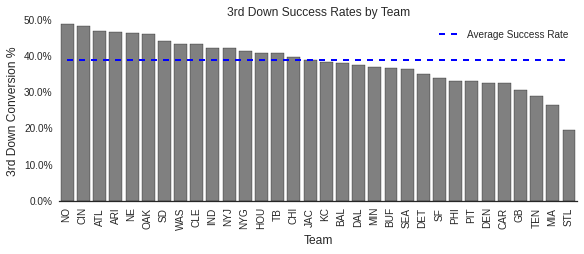

In [3]:
#Build table that shows 3rd down rate by team
third=df.pivot_table(index='team', values='success', aggfunc=[np.sum, len,np.mean])
third.columns=["Conversions", "Attempts", "Conv_Rate"]
third.sort("Conv_Rate", ascending=False, inplace=True)


#............Plot the third down rate by team....................
plt.figure()

g = sns.factorplot(x=third.index, y="Conv_Rate", data=third, aspect=2, kind='bar',
                  color="gray")
g.set_xticklabels(rotation=90)

sns.despine(left=True)
plt.gca().yaxis.set_major_formatter(formatter)
plt.gca().set_ylabel("3rd Down Conversion %", fontsize=12)
plt.gca().set_xlabel("Team", fontsize=12)

plt.plot(np.ones(32)*df["success"].mean(),lw=2, color="blue",linestyle="--", 
         label="Average Success Rate")
plt.title("3rd Down Success Rates by Team")
plt.legend()

plt.show()

A team's 3rd down performance can be due to facing more challenging situations, or it may be because the offense just does not do well on third down.  The graph below shows how teams are performing, compared to what we'd expect for their average 3rd down distance.

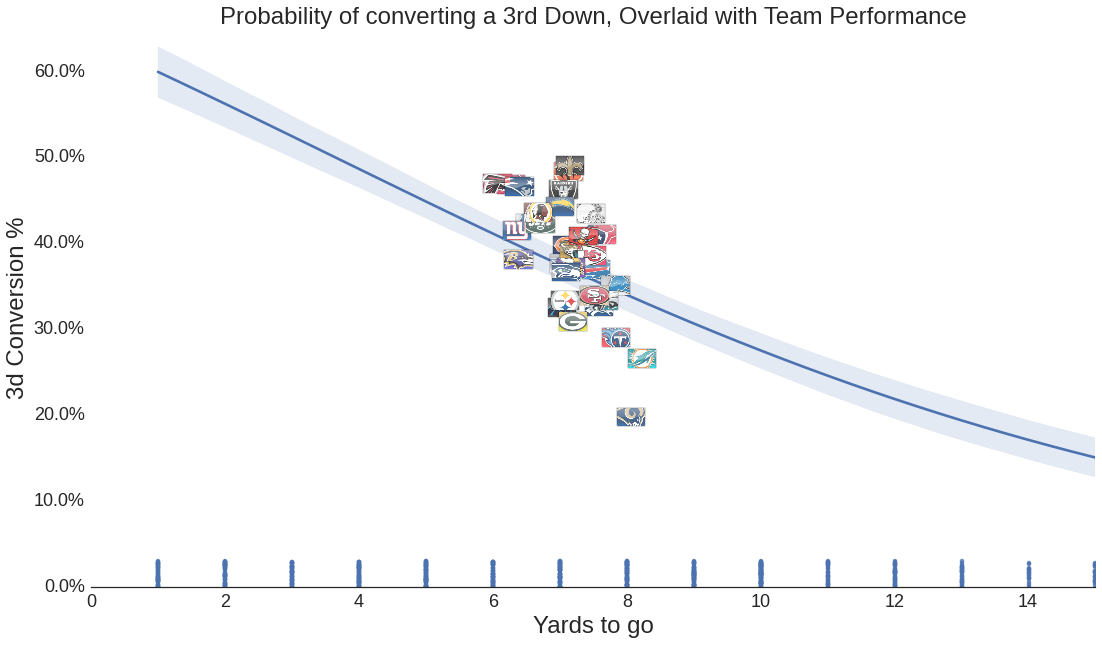

In [4]:
#Build a Series with avg ytg for each team
avgdist=df.pivot_table(index='team', values='ytg', aggfunc=np.mean)
avgdist=avgdist.sort_index()
avgdist.name="avgdist"

third=third.sort_index()

#Plot third down performance by team vs. logistic regression expectation

plt.figure()

sns.regplot(x="ytg", y="success",data=df,logistic=True, y_jitter=.03, truncate=True )
plt.scatter(x=avgdist, y=third["Conv_Rate"], color="red")
plt.xlim(0,15)
plt.ylim(0,.65)

sns.despine(left=True)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.title("Probability of converting a 3rd Down, Overlaid with Team Performance", 
          fontsize=24)
plt.gca().yaxis.set_major_formatter(formatter)
plt.gca().set_ylabel("3d Conversion %", fontsize=24)
plt.gca().set_xlabel("Yards to go", fontsize=24)

for label, x, y in zip(avgdist.index, 
                       avgdist, 
                       third["Conv_Rate"]):
    teamlabel()
    
    

There are 2 reasons (besides the inheret luck involved) that a team's third down performance would deviate from the expectation when looking at their average yards to go. 

1.  The team is simply better (or worse) than the rest of the league at converting third downs when controlling for distance.

2.  The team's average yards to go is skewed by some out of the ordinary third and longs, so their expected 3rd down conversion rate is lower than it would be if we looked more granularly at the distance they face on third downs.  

For instance, a team with an average yards to of 7 yards to go could have an expected conversion rate of 38% (.38 * 3 / 3) if all of their conversions are from 7 yards out, or they could have an expected conversion rate of more than 40% if two out of of every three third downs has one yard remaining, and the third is 3rd and 20 ((.6 + .6 + .1) / 3).  

Below I break down each team's third downs by distance, to better understand the types of situations teams are putting themselves into on third down:

Short [0-3]
Medium (3-6]
Long (6-10]
XLong (10+)

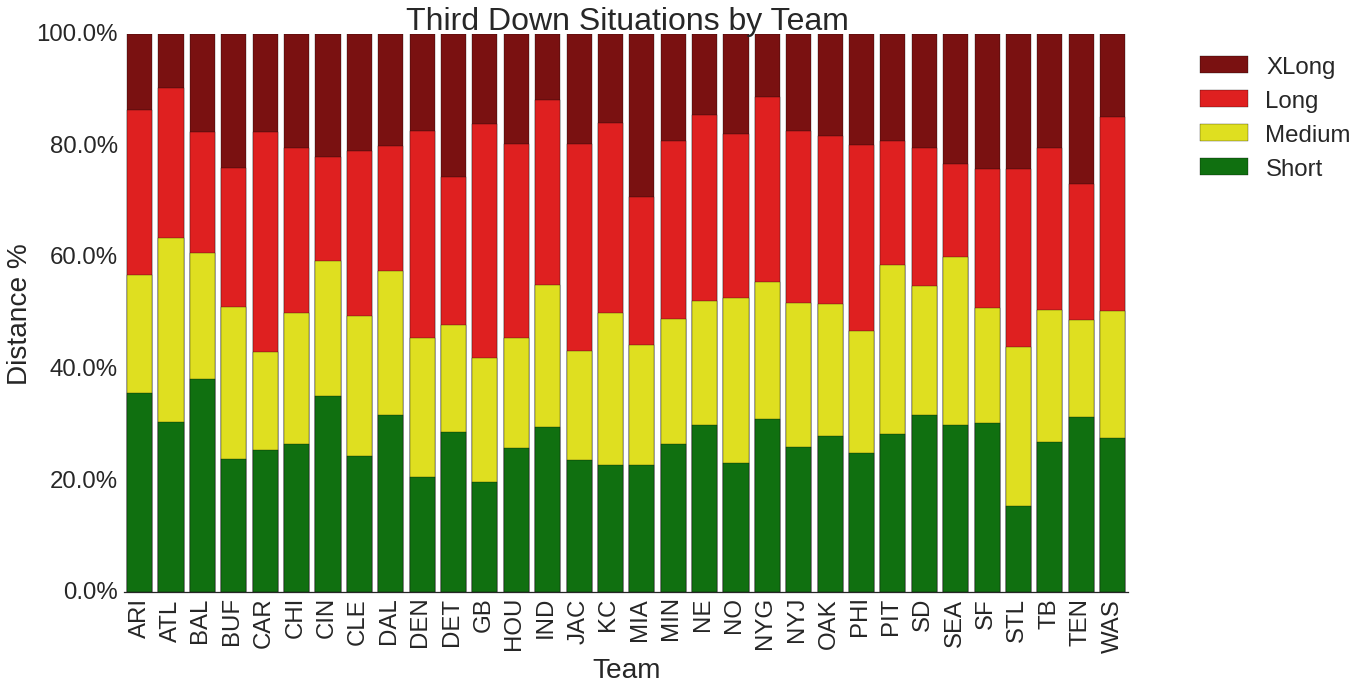

In [5]:
labels=['short','mid','long','long+']

#Build distance buckets for 3rd down distance
df['ytgBuckets']=pandas.cut(df.ytg, [0,3,6,10,50], right=True, labels=labels,retbins=False,
                            precision=3, include_lowest=False).astype("str")

distfreq=df.pivot_table(index='team', columns='ytgBuckets', values='success', aggfunc=len)
distfreq=distfreq[labels]
distfreq=distfreq.divide(distfreq.sum(axis=1), axis='rows')

#Build graph to show Expect 3rd Down rankings.
sns.set_style("white")


sns.barplot(x = distfreq.index , y = distfreq.sum(axis=1), color = "darkred", label="XLong")
sns.barplot(x = distfreq.index , y = distfreq[distfreq.columns[:-1]].sum(axis=1), 
            color = "red", label="Long")
sns.barplot(x = distfreq.index , y = distfreq[distfreq.columns[:-2]].sum(axis=1), 
            color = "yellow", label="Medium")
bottom_plot=sns.barplot(x = distfreq.index , y = distfreq[distfreq.columns[:-3]].sum(axis=1), 
            color = "green", label="Short")
sns.despine(left=True)
plt.gca().yaxis.set_major_formatter(formatter)
plt.title("Third Down Situations by Team", fontsize=32)
bottom_plot.set_ylabel("Distance %", fontsize=28)
bottom_plot.set_xlabel("Team", fontsize=28)
plt.xticks(fontsize=24, rotation=90)
plt.yticks(fontsize=24)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, prop={'size':24})

#bottom_plot.set_xticklabels(rotation=90)


The graph below looks at how we'd expect teams to rank in 3rd down conversion rate, if they converted at league average for each of their 3rd down situations.

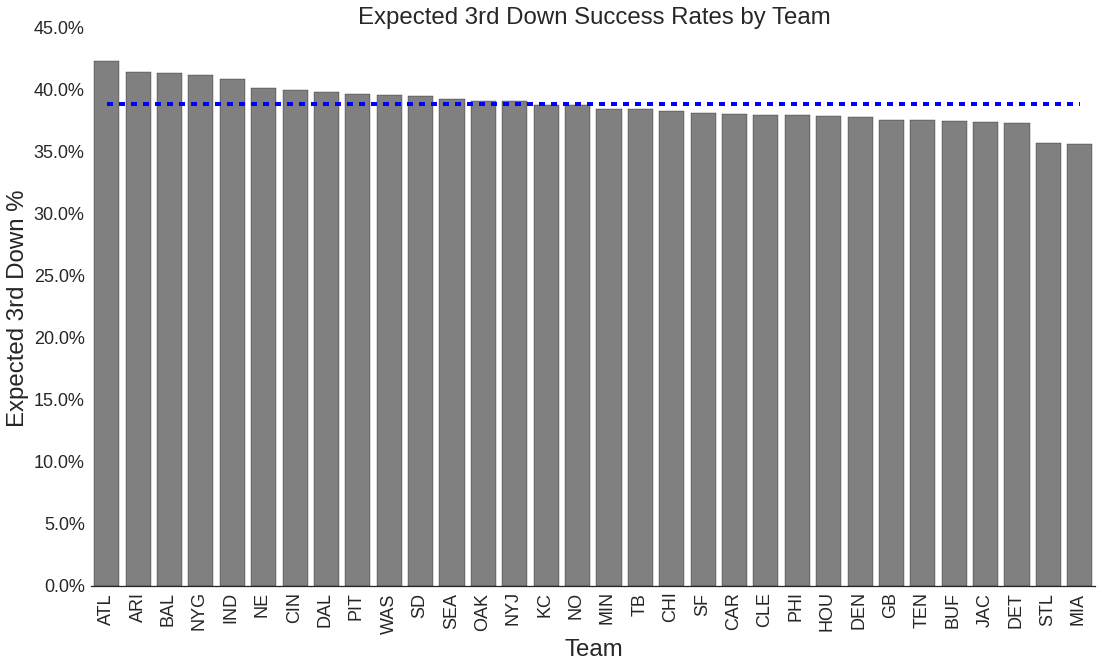

In [6]:
#Table that shows third down attempts and rate by team and distance
#thirdytg=df.pivot_table(index='team', columns='ytgBuckets', values='success', aggfunc=[len,  np.mean])

#NFL 3rd down rates by distance
lenmeans=df.pivot_table(columns='ytgBuckets', values='success', aggfunc=np.mean)
e3d=distfreq.multiply(
    lenmeans, axis=1).sum(axis=1)

e3d.name="e3d"
try:
    third=third.join(e3d)

except:
    pass

third['expsuccess']=third['Attempts'] * third['e3d']
third.sort('e3d', inplace=True, ascending=False)
plt.plot(np.ones(32)*df["success"].mean(),lw=4, color="blue",linestyle="--", 
         label="Average Success Rate")
plt.title("Expected 3rd Down Success Rates by Team", fontsize=24)

sns.despine(left=True)
sns.barplot(x = third.index , y = third.e3d, color="gray")
plt.gca().yaxis.set_major_formatter(formatter)
plt.gca().set_ylabel("Expected 3rd Down %", fontsize=24)
plt.gca().set_xlabel("Team", fontsize=24)
plt.xticks(fontsize=18,rotation=90)
plt.yticks(fontsize=18)
plt.show()

The final graph compares the total # of 3rd down conversions for each team we would expect if they had performed at league average compared to how many how many they have actually converted to see which teams are most benefitting or being hurt by their third down performance.

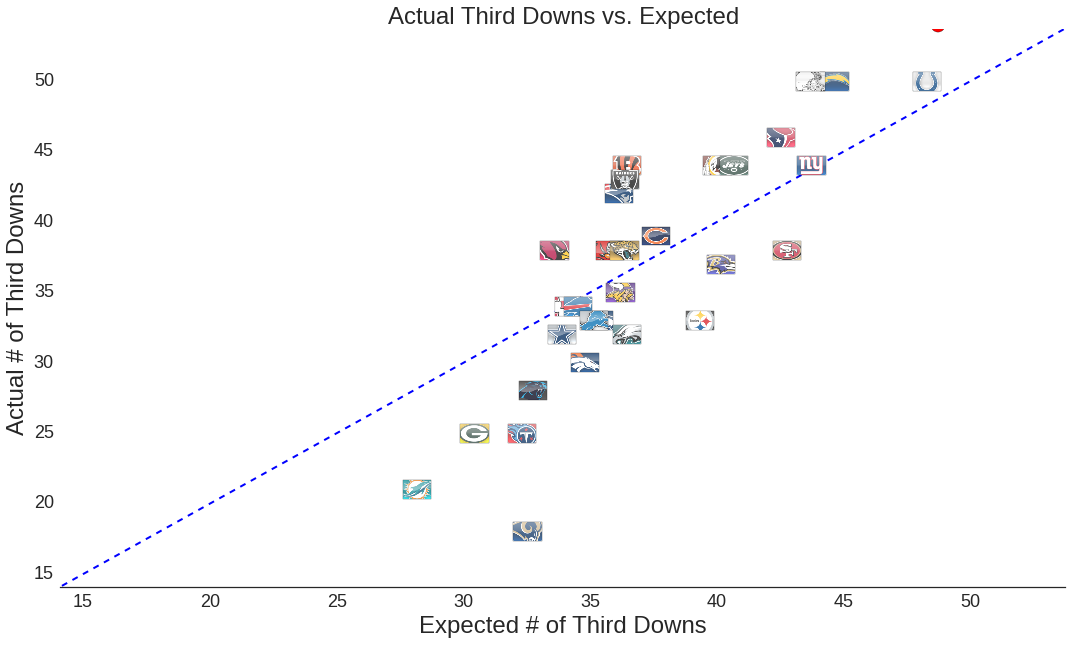

In [7]:
sns.set_style("white")


g=plt.scatter(x=third.expsuccess, y=third.Conversions, s=200, c="red")

plt.plot(np.arange(0,70,1),lw=2, color="blue",linestyle="--", label="Average Success Rate")

plt.axis([third.expsuccess.min()/2,third.expsuccess.max()+5,\
          third.expsuccess.min()/2,third.expsuccess.max()+5])
plt.title("Actual Third Downs vs. Expected", fontsize=24)
plt.xlabel("Expected # of Third Downs", fontsize=24)
plt.ylabel("Actual # of Third Downs", fontsize=24)
sns.despine(left=True)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

for label, x, y in zip(third.index, 
                       third["expsuccess"], 
                       third["Conversions"]):
    teamlabel()


Thanks for taking a look.  Feel free to borrow from the visualizations or the code for your own analyses.  I'd love to see how people are using this, so if you do use it, please send me a note on Twitter @FootballActuary.  I plan to build out more notebooks like this to highlight team performance in other facets of the game, like in the redzone and early/late in games so follow me to be notified as they come out.  Thanks!